In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

In [2]:
class KNearestNeighbors:
    def __init__(self, k, eps=1e-8):
        self.k = k
        self.eps = eps
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        distances = self.compute_distance(X_test)
            
        return self.predict_labels(distances)
        
    def compute_distance(self, X_test):
        # num_test = X_test.shape[0]
        # num_train = self.X_train.shape[0]
        # distances = np.zeros((num_test, num_train))
        
        # for i in range(num_test):
        #     distances[i, :] = np.sqrt(np.sum((self.X_train - X_test[i, :])**2, axis=1))
        
        X_test_sq = np.sum(X_test**2, axis=1, keepdims=True)
        X_train_sq = np.sum(self.X_train**2, axis=1, keepdims=True)
        X_prod = np.dot(X_test, self.X_train.T)
        distances = np.sqrt(self.eps + X_test_sq - 2*X_prod + X_train_sq.T)
        
        return distances
            
    def predict_labels(self, distances):
        num_test = distances.shape[0]
        y_pred = np.zeros(num_test)
        
        for i in range(num_test):
            y_indices = np.argsort(distances[i,:])
            k_closest_classes = self.y_train[y_indices[:self.k]].astype(int)
            y_pred[i] = np.argmax(np.bincount(k_closest_classes))
            
        return y_pred
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return sum(y_pred==y)/y.shape[0]        

In [3]:
def cross_validation(
    model,
    folds=10,
    root_name_X = 'trainData',
    root_name_y = 'trainLabels',
    root_path = '/home/jivjotsingh/Desktop/PracticeML/ML@Waterloo/knn-dataset/'
    ):
    X_subsets = [np.loadtxt(root_path + root_name_X + f'{i+1}.csv', delimiter=',') for i in range(folds)]
    y_subsets = [np.loadtxt(root_path + root_name_y + f'{i+1}.csv', delimiter=',') for i in range(folds)]
    train_accuracy = 0
    validation_accuracy = 0
    
    for i in range(folds):
        val_X_subset, val_y_subset = X_subsets[0], y_subsets[0]
        X_subsets.remove(val_X_subset)
        y_subsets.remove(val_y_subset)
        
        X_stacked, y_stacked = np.vstack(tuple(X_subsets)), np.hstack(tuple(y_subsets))
        
        model.fit(X_stacked, y_stacked)
        train_accuracy += model.accuracy(X_stacked, y_stacked)
        validation_accuracy += model.accuracy(val_X_subset, val_y_subset)
        
        X_subsets.append(val_X_subset)
        y_subsets.append(val_y_subset)
    return train_accuracy/folds, validation_accuracy/folds

In [4]:
train_record, validation_record = [], []
k_range = range(1,31)

for k in k_range:
    KNN = KNearestNeighbors(k)
    t, v = cross_validation(KNN, 10)
    train_record.append(t), validation_record.append(v)

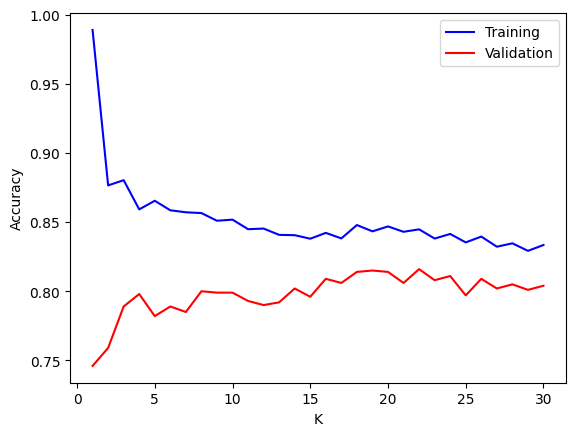

Optimal k value: 22


In [5]:
plt.plot(k_range, train_record, 'blue', label='Training')
plt.plot(k_range, validation_record, 'red', label='Validation')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
k_star = k_range[np.argmax(validation_record)]
print(f'Optimal k value: {k_star}')

In [6]:
root_path = '/home/jivjotsingh/Desktop/PracticeML/ML@Waterloo/knn-dataset/'
X_ = [np.loadtxt(root_path+f'trainData{i+1}.csv', delimiter=',') for i in range(10)]
y_ = [np.loadtxt(root_path+f'trainLabels{i+1}.csv', delimiter=',') for i in range(10)]
X_test = np.loadtxt(root_path+'testData.csv', delimiter=',')
y_test = np.loadtxt(root_path+'testLabels.csv', delimiter=',')
X_stacked, y_stacked = np.vstack(tuple(X_)), np.hstack(tuple(y_))
KNN = KNearestNeighbors(k=k_star)
KNN.fit(X_stacked, y_stacked)
print(f'Training Accuracy: {round(KNN.accuracy(X_stacked, y_stacked),3)}')
print(f'Test Accuracy: {round(KNN.accuracy(X_test, y_test),3)}')

Training Accuracy: 0.848
Test Accuracy: 0.809


In [7]:
def visualize_2Dboundary(model, X, y, mesh_size=0.2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                         np.arange(y_min, y_max, mesh_size))
    z = np.array([xx.ravel(), yy.ravel()]).T
    predictions = model.predict(z)
    fig = px.scatter(x=X[:,0], y=X[:,1], color=y_stacked,
                     color_continuous_scale=['red', 'yellow'])
    fig.add_contour(x=xx.flatten(), y=yy.flatten(), z=predictions,
                    opacity=0.5, showscale=False, colorscale=['red', 'yellow']
                    )
    fig.update_coloraxes(showscale=False)
    fig.update_layout(width=600, height=600, template='plotly_dark')
    return fig

In [9]:
pca = PCA(n_components=2)
history = []
X_reduced = pca.fit_transform(X_stacked)
for i in range(1,51):
    knn = KNearestNeighbors(i)
    knn.fit(X_reduced, y_stacked)
    history.append(knn.accuracy(X_reduced, y_stacked))
    fig = visualize_2Dboundary(knn, X_reduced, y_stacked, 0.5)
    fig.write_image(f'/home/jivjotsingh/Desktop/GitHubRepos/MLfromScratch/images/{i}.png')

In [27]:
epochs=51
import os
from PIL import Image, ImageDraw, ImageFont
def create_animation(image_folder, output_path, frame_duration=100, loop=True):
    images = []
    font_size = 15
    for i in range(1, epochs):
        filename = f'{i}.png'
        image_path = os.path.join(image_folder, filename)
        img = Image.open(image_path)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf", size=font_size)
        draw.text((40, 40), f'k: {i}/{epochs-1} \nAccuracy: {history[i-1]}', fill='white', font=font)
        draw.text((220,40), f'K-Nearest Neighbors', fill='white', font=font, align='center')
        images.append(img)
    images[0].save(output_path, save_all=True, append_images=images[1:], duration=frame_duration, loop=0 if loop else 1)

if __name__ == "__main__":
    folder_path = "/home/jivjotsingh/Desktop/GitHubRepos/MLfromScratch/images"
    output_gif_path = "knn.gif"
    frame_duration_ms = 300
    loop_animation = True
    create_animation(folder_path, output_gif_path, frame_duration_ms, loop_animation)